<a href="https://colab.research.google.com/github/bohdanuhryn/sar_data_mining/blob/main/Software_Aging_Forecasting_in_Android_using_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Functions

In [1]:
# @title Show Boxplots
import matplotlib.pyplot as plt
import seaborn as sn

def show_boxplots(data):
  # Визначаємо числові колонки
  numerical_columns = data.select_dtypes(include=['float64', 'int64']).columns

  # Визначаємо кількість рядків і колонок для підграфіків
  n_cols = 5
  n_rows = (len(numerical_columns) + 1) // n_cols

  # Створюємо boxplots для кожної числової ознаки
  plt.figure(figsize=(15, n_rows * 5))

  for i, column in enumerate(numerical_columns):
    plt.subplot(n_rows, n_cols, i + 1)
    sn.boxplot(y=column, data=data)
    plt.title(column)
    plt.tight_layout()

  plt.show()

In [2]:
# @title Show Heatmap
def show_heatmap(data):
  dataForCorr = data[[
                    'launch_time',
                    'draw_time_avg',
                    'draw_time_median',
                    'total_frames',
                    'total_frames_median',
                    'janky_frames',
                    'janky_frames_median',
                    'janky_ratio',
                    'janky_ratio_median',
                    'missed_vsync_count',
                    'high_input_latency_count',
                    'slow_ui_thread_count',
                    'slow_bitmap_uploads_count',
                    'slow_issue_draw_commands_count'
                    ]]

  #corrMatrix = dataForCorr.corr(method="pearson")
  #corrMatrix = dataForCorr.corr(method="kendall")
  corrMatrix = dataForCorr.corr(method="spearman")

  plt.figure(figsize=(10, 8))

  sn.heatmap(corrMatrix, annot=True)

  plt.show()

In [3]:
# @title Show Z-score

def get_z_score(data, threshold = 3):
  print("\nZ-score:")
  z_scores = (data - data.mean()) / data.std()

  outliers = z_scores[(z_scores > threshold) | (z_scores < -threshold)].any(axis=1)

  outliers_data = data[outliers]

  print(f'\nOutliers count: {len(outliers_data)}')

  cleaned_data = data[~outliers]

  return cleaned_data

In [4]:
# @title Default Estimator Models

from typing import Dict
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LassoLars
from sklearn.linear_model import SGDRegressor
from sklearn.svm import LinearSVR
from sklearn.svm import SVR
from sklearn.svm import NuSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.base import BaseEstimator

def defaultEstimatorModels() -> Dict[str, BaseEstimator]:
  linear_models = {
      'Linear Regression': LinearRegression(),
      'Ridge': Ridge(),
      'BayesianRidge': BayesianRidge(),
      'Lasso': Lasso(),
      'ElasticNet': ElasticNet(),
      'LassoLars': LassoLars(),
      'SGDRegressor': SGDRegressor()
  }

  svr_models = {
      'LinearSVR': LinearSVR(),
      'NuSVR': NuSVR(),
      'SVR': SVR()
  }

  ensemble_models = {
      'Random Forest': RandomForestRegressor()
  }

  neighbors_models = {
      'KNeighborsRegressor': KNeighborsRegressor()
  }

  nn_models = {
      'MLPRegressor': MLPRegressor()
  }

  models = {
      **linear_models,
      **svr_models,
      **ensemble_models,
      **neighbors_models,
      **nn_models
  }
  return models

In [5]:
# @title Compare ML algorithms

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import List
from typing import Dict
from pandas import DataFrame
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit
from sklearn.base import BaseEstimator
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score, make_scorer

# Підготовка даних для моделі (створюємо лаги)
def create_lags(
    df: DataFrame,
    column: str,
    n_lags: int = 1
) -> None:
  df_copy = df.copy()
  for i in range(1, n_lags + 1):
    df_copy[f'lag_{i}'] = df_copy[column].shift(i)
  df_copy.dropna(inplace=True)
  return df_copy

def cross_validation_evaluator(model: BaseEstimator, x, y, cv):
  mse_scores = cross_val_score(model, x, y, cv=cv, scoring='neg_mean_squared_error')
  mae_scores = cross_val_score(model, x, y, cv=cv, scoring='neg_mean_absolute_error')
  r2_scores = cross_val_score(model, x, y, cv=cv, scoring='r2')
  mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)
  mape_scores = cross_val_score(model, x, y, cv=cv, scoring=mape_scorer)

  mse = -mse_scores.mean()
  rmse = np.sqrt(-mse_scores.mean())
  mae = -mae_scores.mean()
  r2 = r2_scores.mean()
  mape = -mape_scores.mean()

  return {
      'MSE': mse,
      'RMSE': rmse,
      'MAE': mae,
      'R2': r2,
      'MAPE': mape
  }

# Порівняння регресійних алгоритмів
def find_best_regression_algorithm(
    df: DataFrame,
    data_feature: str,
    target_feature: str
) -> BaseEstimator:
  # Вибрані колонки характеристик та прогнозування
  selected_columns = [data_feature, target_feature]

  # Відфільтрований набір даних
  df = df[selected_columns].copy()

  df.set_index(data_feature, inplace=True)

  # Кількість лагів
  n_lags = 20

  # Оновити набір даних з лагами
  df = create_lags(df, target_feature, n_lags)

  # Визначаємо точку розбиття (наприклад, 80% для тренувального набору, 20% для тестового)
  split_point = int(len(df) * 0.8)

  # Розділяємо дані
  train, test = df.iloc[:split_point], df.iloc[split_point:]

  # Тренувальні дані з лагами
  X_train, y_train = train.drop(target_feature, axis=1), train[target_feature]

  X_train_len = len(X_train)

  # Тестові дані з лагами
  X_test, y_test = test.drop(target_feature, axis=1), test[target_feature]

  # Набір моделей з параметрами за замовчуванням
  models = defaultEstimatorModels()

  # Time Series Split for cross-validation
  tscv = TimeSeriesSplit(n_splits=5)

  # Evaluate models using cross-validation
  cv_results = {}
  for name, model in models.items():
    results = cross_validation_evaluator(model, X_train, y_train, tscv)
    cv_results[name] = results

  print('CV results:')
  cv_results_df = pd.DataFrame(cv_results).T
  print(cv_results_df)

  # Вибір найкращої моделі за метрикою R²
  best_model_name = max(cv_results, key=lambda name: cv_results[name]['R2'])
  best_model = models[best_model_name]

  # Навчання найкращої моделі на навчальній вибірці
  best_model.fit(X_train, y_train)

  # Останні відомі значення для створення початкових лагів
  last_known_values = df[target_feature].values[(X_train_len - n_lags):X_train_len]
  print(f'last_known_values: {last_known_values}')

  n_steps = len(X_test)

  # Передбачення на тестовій вибірці
  #predictions = best_model.predict(X_test)
  predictions = forecast_next_values(best_model, last_known_values, n_steps, n_lags)

  # Оцінка моделі на тестовій вибірці
  mse = mean_squared_error(y_test, predictions)
  rmse = np.sqrt(mse)
  mae = mean_absolute_error(y_test, predictions)
  r2 = r2_score(y_test, predictions)
  mape = mean_absolute_percentage_error(y_test, predictions)

  # Виведення метрик
  best_model_results = {
          'MSE': [mse],
          'RMSE': [rmse],
          'MAE': [mae],
          'R2': [r2],
          'MAPE': [mape]
  }
  print(f'Best Model: {best_model_name}')
  best_model_results_df = pd.DataFrame(best_model_results).T
  print(best_model_results_df)

  # Побудова графіку фактичних та прогнозованих значень
  plt.figure(figsize=(14, 7))
  plt.plot(df.index, df[target_feature], label='Actual')
  plt.plot(X_train.index, best_model.predict(X_train), label='Trained')
  plt.plot(y_test.index, predictions, label='Predicted', linestyle='--')
  plt.xlabel('Date')
  plt.ylabel('Value')
  plt.title(f'Actual vs Predicted Values ({best_model_name})')
  plt.legend()
  plt.show()

  return best_model

# Прогнозування на нових даних
def forecast_next_values(model, last_known_values, n_steps, n_lags):
  predictions = []
  current_values = last_known_values.copy()

  for _ in range(n_steps):
    # Створення лагів для поточного набору даних
    lagged_values = current_values[-n_lags:].reshape(1, -1)
    # Прогнозування наступного значення
    next_value = model.predict(lagged_values)[0]
    predictions.append(next_value)
    # Додавання нового прогнозованого значення до набору даних
    current_values = np.append(current_values, next_value)

  return predictions

def forecast_aging(
    model: BaseEstimator,
    df: DataFrame,
    data_feature: str,
    target_feature: str,
    n_steps: int = 100
) -> None:
  selected_columns = [data_feature, target_feature]

  df = df[selected_columns].copy()

  n_lags = 3

  df = create_lags(df, target_feature, n_lags)

  X, y = df.drop(target_feature, axis=1), df[target_feature]

  # Передбачення на тестовій вибірці
  #predictions = model.predict(X)

  # Останні відомі значення для створення початкових лагів
  last_known_values = df[target_feature].values[-n_lags:]

  # Прогнозування наступних значень
  predictions = forecast_next_values(model, last_known_values, n_steps, n_lags)

  # Оцінка моделі на тестовій вибірці
  mse = mean_squared_error(y, predictions)
  rmse = np.sqrt(mse)
  mae = mean_absolute_error(y, predictions)
  r2 = r2_score(y, predictions)
  mape = mean_absolute_percentage_error(y, predictions)

  # Виведення метрик
  model_results = {
      'MSE': [mse],
      'RMSE': [rmse],
      'MAE': [mae],
      'R2': [r2],
      'MAPE': [mape]
  }
  model_results_df = pd.DataFrame(model_results).T
  print(model_results_df)

  # Побудова графіку фактичних та прогнозованих значень
  plt.figure(figsize=(14, 7))
  plt.plot(X, y, label='Actual')
  plt.plot(X, predictions, label='Predicted', linestyle='--')
  plt.xlabel('Date')
  plt.ylabel('Value')
  plt.title(f'Actual vs Predicted Values')
  plt.legend()
  plt.show()


# Data Understanding

In [6]:
import pandas as pd

multiple_apps_1 = '/content/drive/MyDrive/SAR_Research/Datasets/EXP_April_2021/Timeseries/Flutter_UI-Metrics_TimeSeries_MultipleApps_1.csv'
usage_delays_1 = '/content/drive/MyDrive/SAR_Research/Datasets/EXP_April_2021/Timeseries/Flutter_UI-Metrics_TimeSeries_UsageDelays_1.csv'

#data = pd.read_csv(multiple_apps_1)
data = pd.read_csv(usage_delays_1)

data = data.drop(
    columns=[
        'time_end_sec',
        'percentile_50_ms',
        'percentile_90_ms',
        'percentile_95_ms',
        'percentile_99_ms'
        ]
    )

data.head()

,time_start_sec,launch_time,draw_time_avg,draw_time_median,total_frames,total_frames_median,janky_frames,janky_frames_median,janky_ratio,janky_ratio_median,missed_vsync_count,high_input_latency_count,slow_ui_thread_count,slow_bitmap_uploads_count,slow_issue_draw_commands_count
0,252,0,0.000000,0.000000,32,32,13,13,0.688525,0.688525,4,0,4,0,10
1,282,524001,33.971844,8.807977,0,1,0,0,0.333333,0.000000,0,0,0,0,0
2,312,0,0.000000,0.000000,77,0,71,0,0.383463,0.000000,64,0,71,70,2
3,342,0,53.774960,52.139990,21,2,15,1,0.706061,1.000000,14,0,14,14,3
4,372,0,81.149060,19.907248,0,0,0,0,0.250000,0.000000,0,0,0,0,0


In [7]:
data.describe()

,time_start_sec,launch_time,draw_time_avg,draw_time_median,total_frames,total_frames_median,janky_frames,janky_frames_median,janky_ratio,janky_ratio_median,missed_vsync_count,high_input_latency_count,slow_ui_thread_count,slow_bitmap_uploads_count,slow_issue_draw_commands_count
count,483.000000,483.000000,483.000000,483.000000,483.000000,483.000000,483.000000,483.000000,483.000000,483.000000,483.000000,483.000000,483.000000,483.000000,483.000000
mean,7587.217391,6350.710145,40.489014,24.177047,8.024845,0.546584,2.737060,0.306418,0.236703,0.176275,1.072464,0.002070,1.672878,1.080745,1.283644
std,4248.147424,62575.109424,51.971421,42.757115,20.883380,2.629904,8.981263,0.802809,0.245282,0.341699,5.420199,0.045502,6.774420,6.274140,5.022799
min,252.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3927.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7602.000000,0.000000,23.235334,14.353184,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,11247.000000,0.000000,65.754683,29.067232,1.000000,1.000000,1.000000,0.000000,0.400000,0.086974,0.000000,0.000000,0.000000,0.000000,0.000000
max,14892.000000,701002.000000,359.733060,359.733060,144.000000,47.000000,82.000000,13.000000,0.960000,1.000000,64.000000,1.000000,72.000000,72.000000,68.000000


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 483 entries, 0 to 482
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   time_start_sec                  483 non-null    int64  
 1   launch_time                     483 non-null    int64  
 2   draw_time_avg                   483 non-null    float64
 3   draw_time_median                483 non-null    float64
 4   total_frames                    483 non-null    int64  
 5   total_frames_median             483 non-null    int64  
 6   janky_frames                    483 non-null    int64  
 7   janky_frames_median             483 non-null    int64  
 8   janky_ratio                     483 non-null    float64
 9   janky_ratio_median              483 non-null    float64
 10  missed_vsync_count              483 non-null    int64  
 11  high_input_latency_count        483 non-null    int64  
 12  slow_ui_thread_count            483 

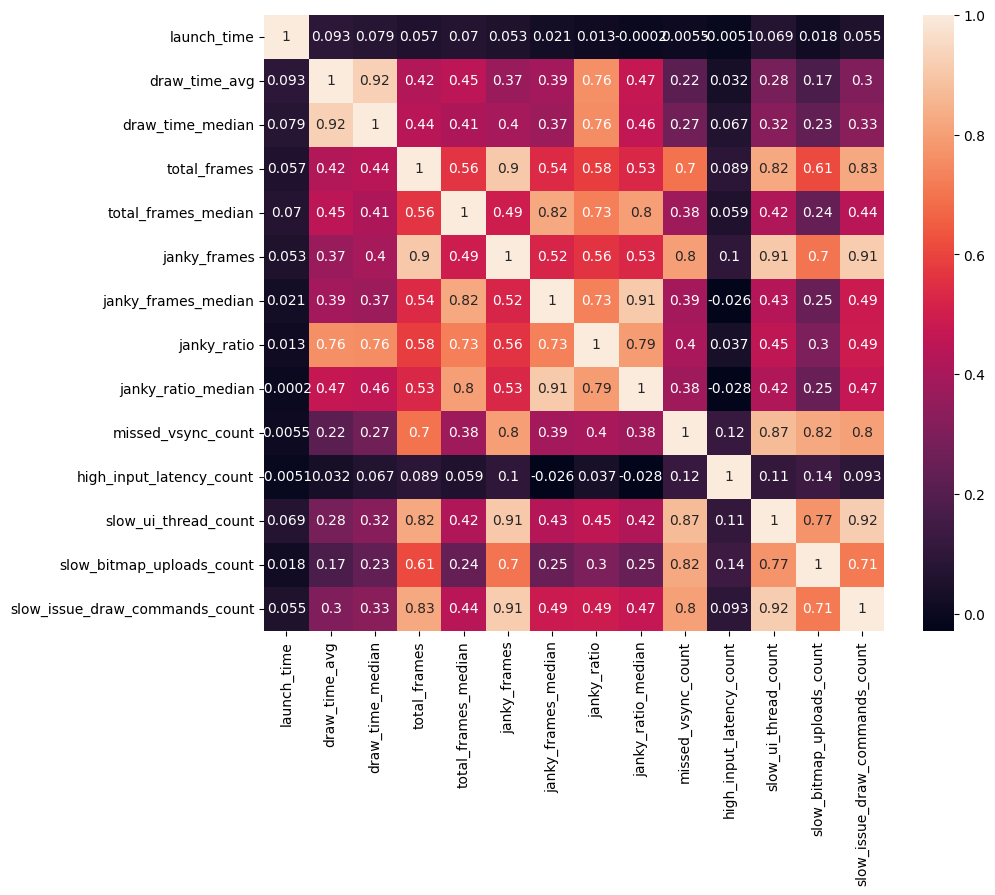

In [9]:
show_heatmap(data)

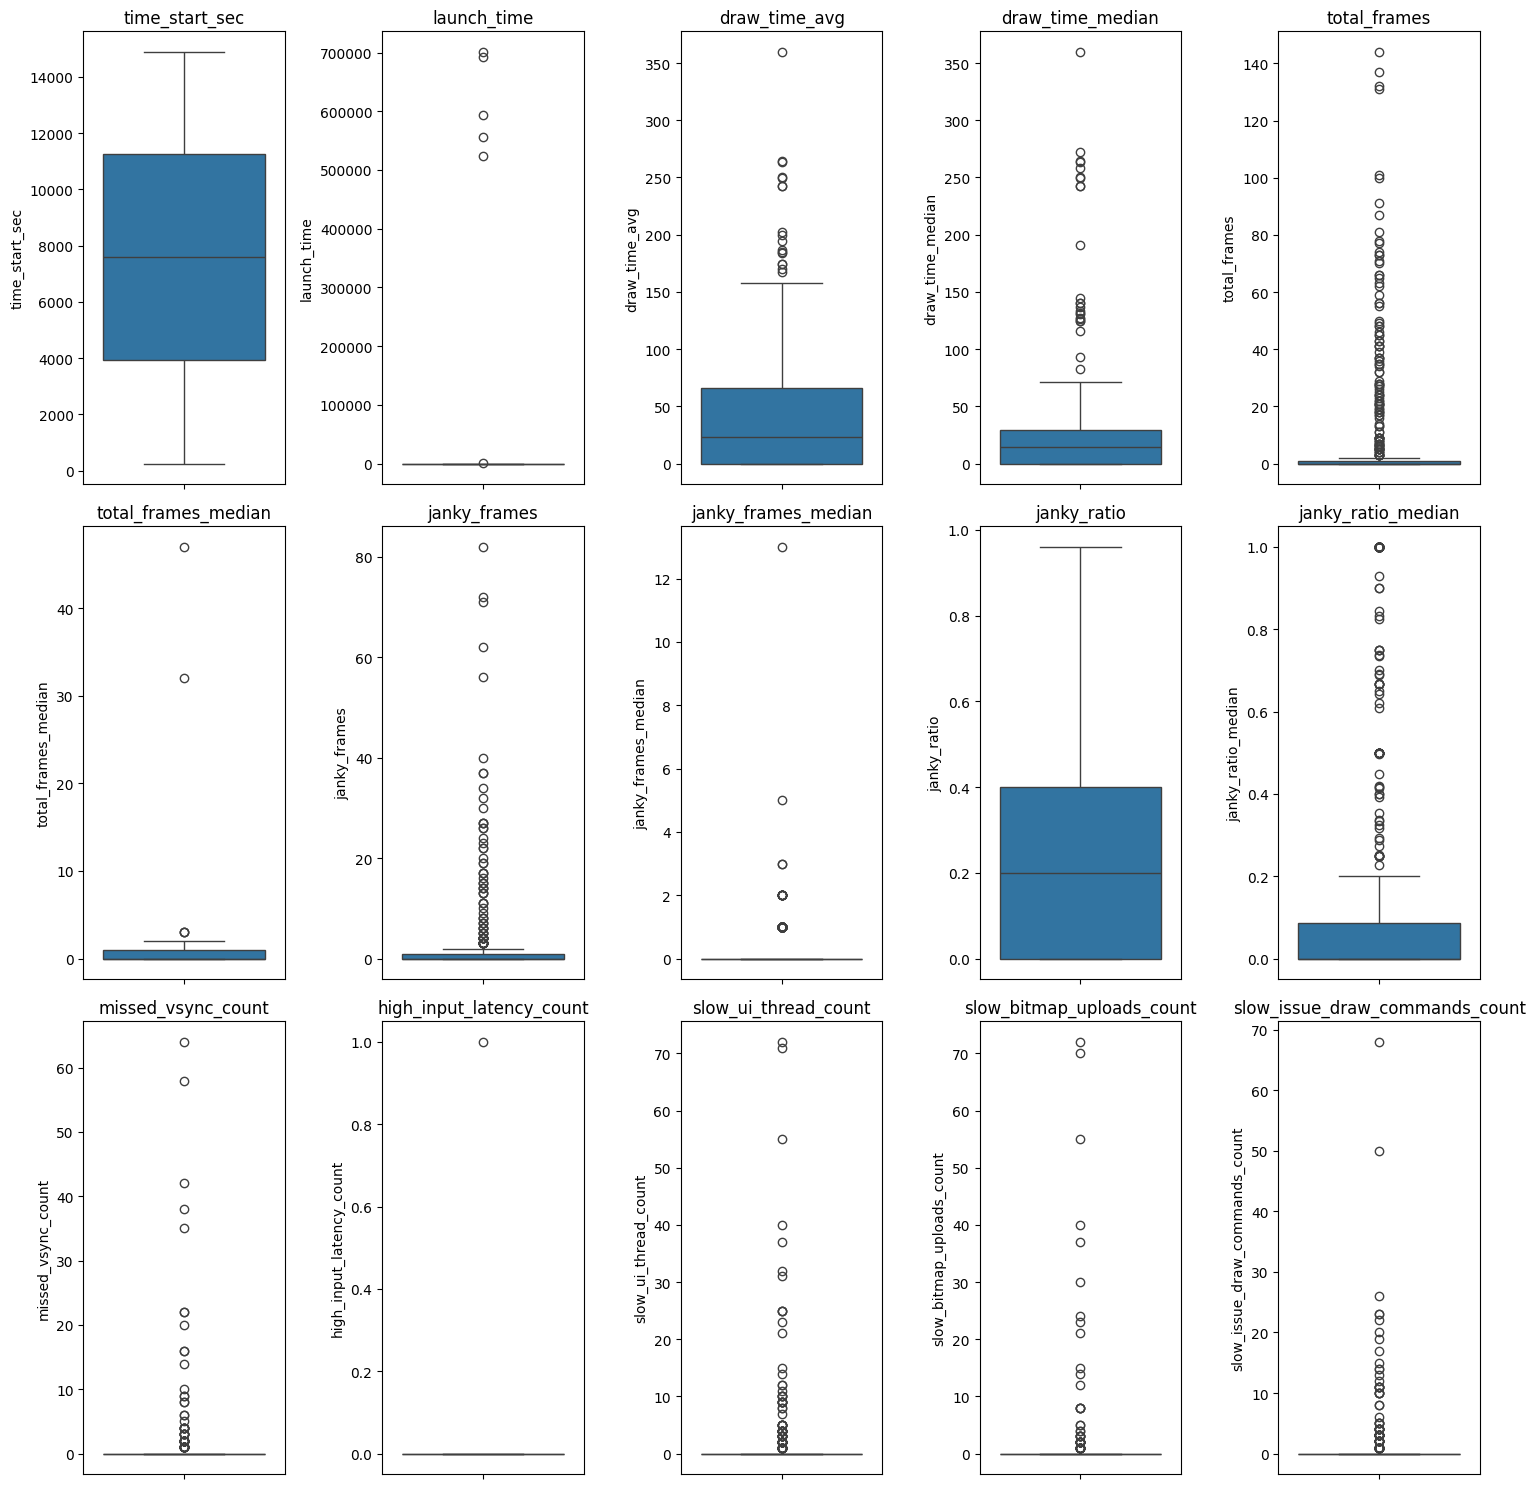

In [10]:
show_boxplots(data)

# Data Preparation


In [11]:
data = get_z_score(data)


Z-score:

Outliers count: 44


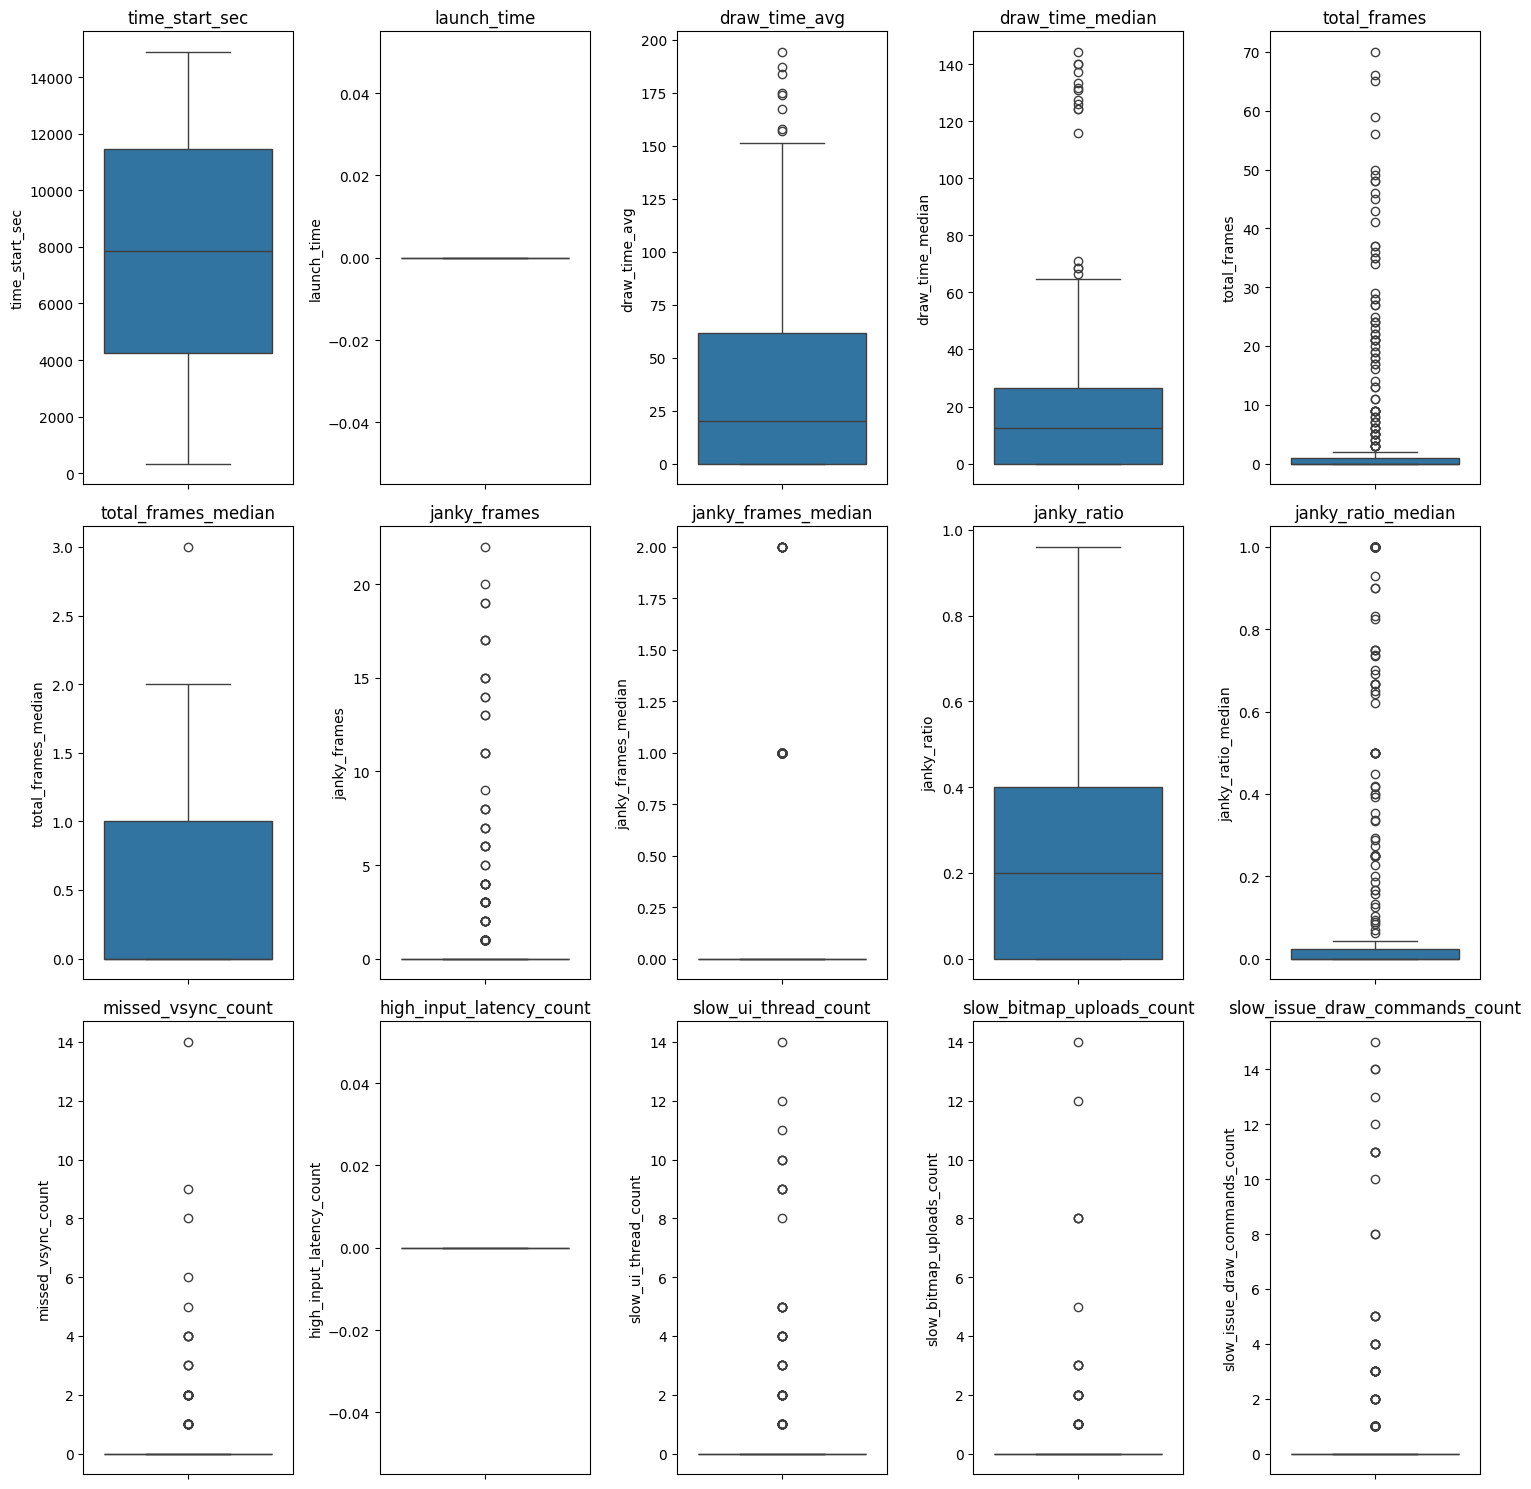

In [12]:
show_boxplots(data)

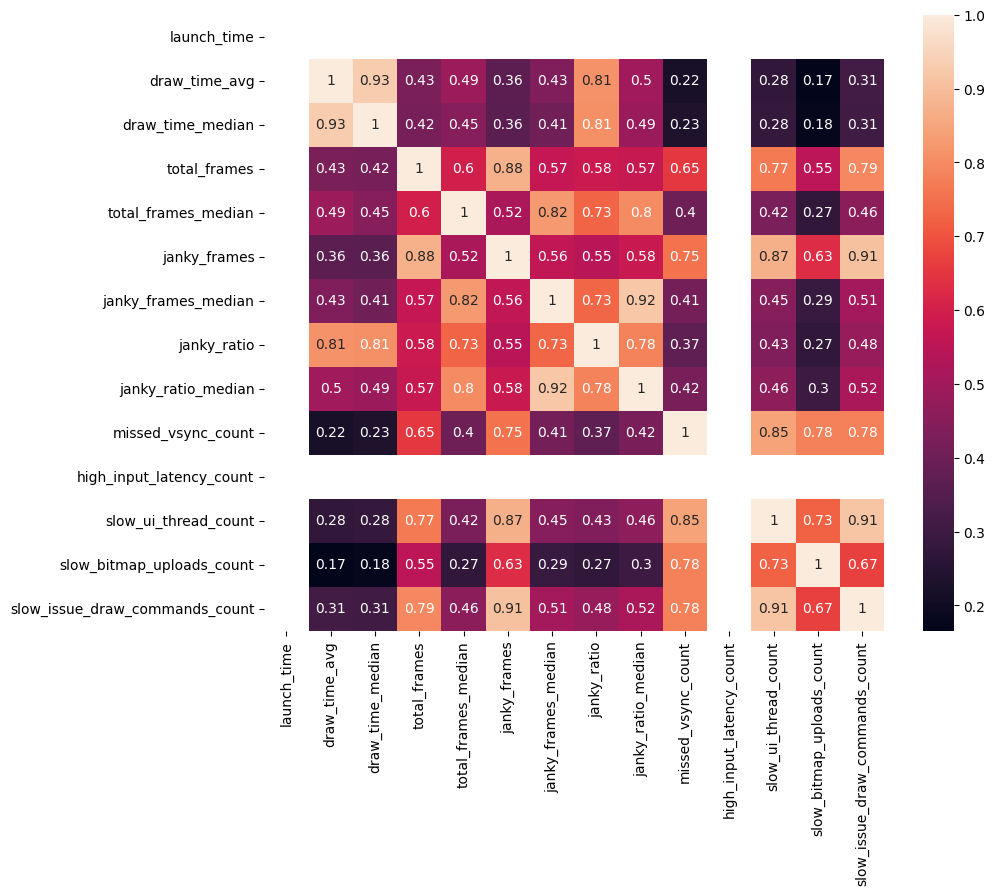

In [13]:
show_heatmap(data)

# Aging Forecast

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppr

CV results:
                              MSE          RMSE           MAE            R2  \
Linear Regression    1.377729e+03  3.711778e+01  2.278884e+01 -2.515647e-02   
Ridge                1.377720e+03  3.711765e+01  2.278876e+01 -2.515202e-02   
BayesianRidge        1.229066e+03  3.505804e+01  2.160029e+01  5.207178e-02   
Lasso                1.370460e+03  3.701972e+01  2.272068e+01 -2.091076e-02   
ElasticNet           1.373440e+03  3.705996e+01  2.274947e+01 -2.268717e-02   
LassoLars            1.370466e+03  3.701981e+01  2.272067e+01 -2.091337e-02   
SGDRegressor         1.425420e+27  3.775473e+13  3.187110e+13 -2.480417e+24   
LinearSVR            1.437587e+03  3.791553e+01  2.326254e+01 -1.249574e-01   
NuSVR                1.784914e+03  4.224824e+01  3.304662e+01 -5.246536e-01   
SVR                  1.725840e+03  4.154323e+01  2.520851e+01 -2.055462e-01   
Random Forest        1.065142e+03  3.263651e+01  1.771434e+01  1.827559e-01   
KNeighborsRegressor  1.378459e+03  3.712

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does

Best Model: Random Forest
                 0
MSE   3.413505e+03
RMSE  5.842520e+01
MAE   4.431005e+01
R2   -1.247401e+00
MAPE  1.762303e+15


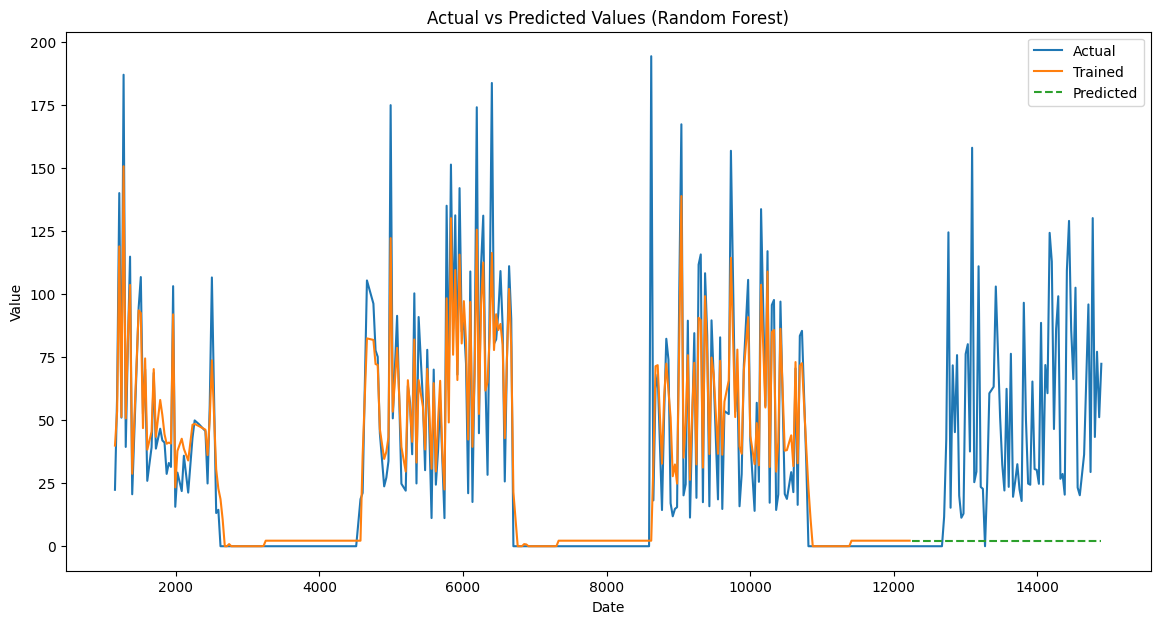

In [14]:
model = find_best_regression_algorithm(
    df=data,
    data_feature='time_start_sec',
    target_feature='draw_time_avg'
)

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppr

CV results:
                              MSE          RMSE           MAE            R2  \
Linear Regression    2.310264e+01  4.806521e+00  3.337163e+00  8.017643e-01   
Ridge                2.309458e+01  4.805682e+00  3.337041e+00  8.018974e-01   
BayesianRidge        2.300664e+01  4.796524e+00  3.358547e+00  8.139719e-01   
Lasso                2.023306e+01  4.498118e+00  3.102763e+00  8.419846e-01   
ElasticNet           2.052959e+01  4.530959e+00  3.145407e+00  8.385460e-01   
LassoLars            2.015181e+01  4.489077e+00  3.097787e+00  8.424219e-01   
SGDRegressor         2.958931e+27  5.439606e+13  1.682010e+13 -3.935769e+24   
LinearSVR            2.505138e+01  5.005135e+00  3.526531e+00  7.487721e-01   
NuSVR                5.694940e+02  2.386407e+01  1.980061e+01 -1.472694e+00   
SVR                  4.883821e+02  2.209937e+01  1.540906e+01 -6.953730e-01   
Random Forest        6.790753e+01  8.240602e+00  4.780982e+00  7.324645e-01   
KNeighborsRegressor  2.844173e+02  1.686

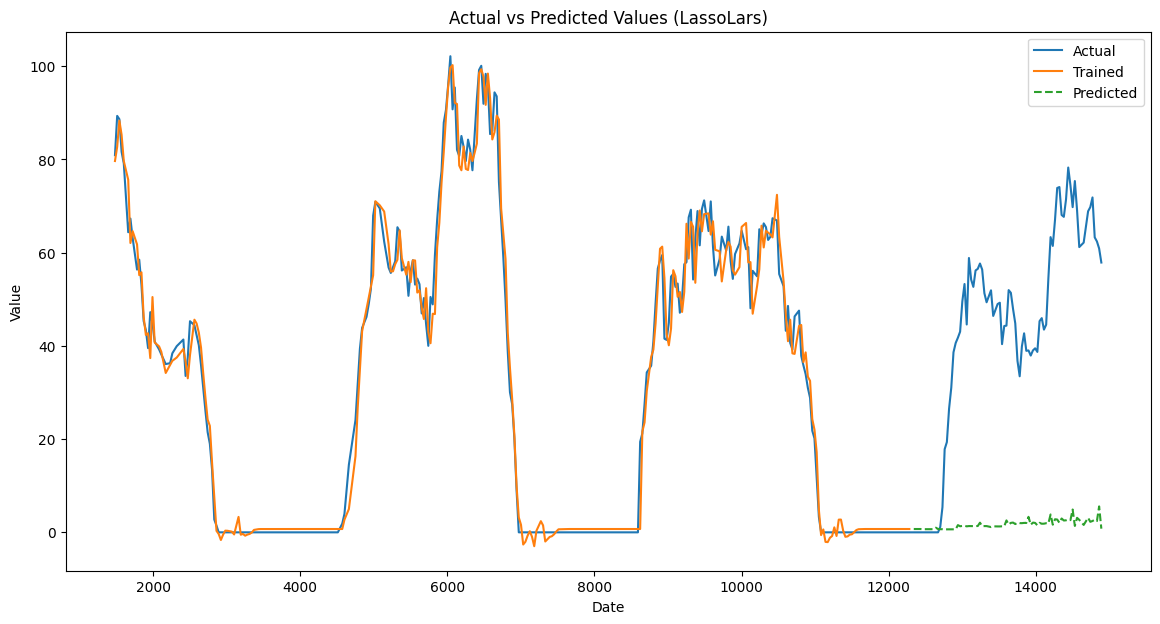

In [18]:
window_size = 10
data['draw_time_avg_moving_avg'] = data['draw_time_avg'].rolling(window=window_size).mean()

updated_data = data.dropna()

model = find_best_regression_algorithm(
    df=updated_data,
    data_feature='time_start_sec',
    target_feature='draw_time_avg_moving_avg'
)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e

CV results:
                          MSE     RMSE      MAE   R2          MAPE
Linear Regression   -0.000000 -0.00000 -0.00000  1.0 -0.000000e+00
Ridge               -0.000000 -0.00000 -0.00000  1.0 -0.000000e+00
BayesianRidge       -0.000000 -0.00000 -0.00000  1.0 -0.000000e+00
Lasso               -0.000000 -0.00000 -0.00000  1.0 -0.000000e+00
ElasticNet          -0.000000 -0.00000 -0.00000  1.0 -0.000000e+00
LassoLars           -0.000000 -0.00000 -0.00000  1.0 -0.000000e+00
SGDRegressor        -0.000000 -0.00000 -0.00000  1.0 -0.000000e+00
LinearSVR           -0.000000 -0.00000 -0.00000  1.0 -0.000000e+00
NuSVR               -0.000000 -0.00000 -0.00000  1.0 -0.000000e+00
SVR                 -0.000000 -0.00000 -0.00000  1.0 -0.000000e+00
Random Forest       -0.000000 -0.00000 -0.00000  1.0 -0.000000e+00
KNeighborsRegressor -0.000000 -0.00000 -0.00000  1.0 -0.000000e+00
MLPRegressor         0.000379  0.01946  0.02166  0.0  6.460474e+13
last_known_values: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature n

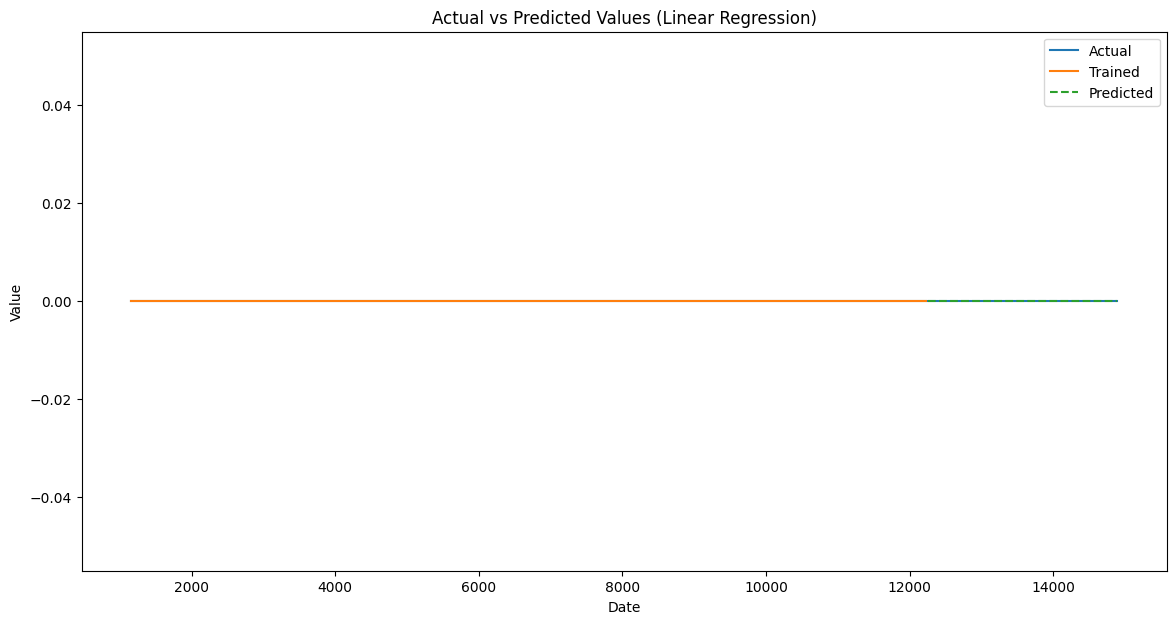

In [16]:
window_size = 100
#data['draw_time_avg_moving_avg'] = data['draw_time_avg'].rolling(window=window_size).mean()

#updated_data = data.dropna()

model = find_best_regression_algorithm(
    df=data,
    data_feature='time_start_sec',
    target_feature='launch_time'
)

In [17]:
# @title Validate model on another dataset

import pandas as pd

validation_data = pd.read_csv('/content/drive/MyDrive/SAR_Research/Datasets/EXP_April_2021/Timeseries/Flutter_UI-Metrics_TimeSeries_UsageDelays_1.csv')

validation_data = validation_data.drop(
    columns=[
        'time_end_sec',
        'percentile_50_ms',
        'percentile_90_ms',
        'percentile_95_ms',
        'percentile_99_ms'
        ]
    )

# Обчислюємо ковзаюче середнє для стовпця 'value'
window_size = 12
validation_data['draw_time_avg_moving_avg'] = validation_data['draw_time_avg'].rolling(window=window_size).mean()

validation_data = validation_data.dropna()

forecast_aging(
    model = model,
    df = validation_data,
    data_feature = 'time_start_sec',
    target_feature = 'draw_time_avg_moving_avg'
)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


ValueError: X has 3 features, but LinearRegression is expecting 20 features as input.